## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.7]
redice_lr_patient = [5, 10, 20]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2727 - accuracy: 0.5575 - val_loss: 1.4801 - val_accuracy: 0.4801
Epoch 12/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2467 - accuracy: 0.5673 - val_loss: 1.4885 - val_accuracy: 0.4781
Epoch 13/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2200 - accuracy: 0.5779 - val_loss: 1.4713 - val_accuracy: 0.4804
Epoch 14/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1954 - accuracy: 0.5859 - val_loss: 1.4675 - val_accuracy: 0.4912
Epoch 15/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1702 - accuracy: 0.5952 - val_loss: 1.4680 - val_accuracy: 0.4858
Epoch 16/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1474 - accuracy: 0.6047 - val_loss: 1.4645 - val_accuracy: 0.4932
Epoch 17/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.1245 - accuracy: 0.6131 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 58us/step - loss: 2.2081 - accuracy: 0.2632 - val_loss: 2.1332 - val_accuracy: 0.2311
Epoch 2/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.7536 - accuracy: 0.3863 - val_loss: 1.9705 - val_accuracy: 0.3020
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6242 - accuracy: 0.4318 - val_loss: 1.8313 - val_accuracy: 0.3671
Epoch 4/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5478 - accuracy: 0.4585 - val_loss: 1.7259 - val_accuracy: 0.4033
Epoch 5/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4928 - accuracy: 0.4795 - val_loss: 1.6507 - val_accuracy: 0.4236
Epoch 6/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4443 - accuracy: 0.4962 - val_loss: 1.5878 - val_accuracy: 0.4462
Epoch 7/25
50000/50000 [==============================] - 2s 46us/st

50000/50000 [==============================] - 2s 46us/step - loss: 1.2293 - accuracy: 0.5737 - val_loss: 1.4912 - val_accuracy: 0.4744
Epoch 21/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2139 - accuracy: 0.5803 - val_loss: 1.4851 - val_accuracy: 0.4757
Epoch 22/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1981 - accuracy: 0.5876 - val_loss: 1.4830 - val_accuracy: 0.4760
Epoch 23/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1826 - accuracy: 0.5916 - val_loss: 1.4784 - val_accuracy: 0.4747
Epoch 24/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.1667 - accuracy: 0.5978 - val_loss: 1.4775 - val_accuracy: 0.4815
Epoch 25/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.1517 - accuracy: 0.6039 - val_loss: 1.4820 - val_accuracy: 0.4794
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
Model: "model_6"
________________________________________________

Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5978 - accuracy: 0.4419 - val_loss: 1.7436 - val_accuracy: 0.3891
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5526 - accuracy: 0.4582 - val_loss: 1.6768 - val_accuracy: 0.4139
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5153 - accuracy: 0.4705 - val_loss: 1.6392 - val_accuracy: 0.4272
Epoch 8/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.4821 - accuracy: 0.4828 - val_loss: 1.6011 - val_accuracy: 0.4373
Epoch 9/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4531 - accuracy: 0.4955 - val_loss: 1.5768 - val_accuracy: 0.4431
Epoch 10/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4281 - accuracy: 0.5027 - val_loss: 1.5599 - val_accuracy: 0.4536
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4031 - accuracy: 0.5116 - val_loss:

50000/50000 [==============================] - 2s 46us/step - loss: 1.1566 - accuracy: 0.6016 - val_loss: 1.4789 - val_accuracy: 0.4843
Numbers of exp: 8, reduce_factor: 0.70, reduce_patient: 20
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
______________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.0027 - accuracy: 0.6476 - val_loss: 1.8121 - val_accuracy: 0.3975
Epoch 11/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9672 - accuracy: 0.6603 - val_loss: 2.0530 - val_accuracy: 0.3603
Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9265 - accuracy: 0.6745 - val_loss: 2.1487 - val_accuracy: 0.3442
Epoch 13/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.8931 - accuracy: 0.6865 - val_loss: 1.7061 - val_accuracy: 0.4270
Epoch 14/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.8522 - accuracy: 0.7024 - val_loss: 1.8109 - val_accuracy: 0.4133

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.7170 - accuracy: 0.7577 - val_loss: 1.5836 - val_accuracy: 0.4716
Epoch 16/25
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.9285 - accuracy: 0.3420 - val_loss: 2.0746 - val_accuracy: 0.2189
Epoch 2/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5890 - accuracy: 0.4465 - val_loss: 1.8882 - val_accuracy: 0.3299
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4944 - accuracy: 0.4767 - val_loss: 1.7584 - val_accuracy: 0.3965
Epoch 4/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4337 - accuracy: 0.5001 - val_loss: 1.6580 - val_accuracy: 0.4425
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3865 - accuracy: 0.5166 - val_loss: 1.5808 - val_accuracy: 0.4617
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3465 - accuracy: 0.5310 - val_loss: 1.5590 - val_accuracy: 0.4614
Epoch 7/25
50000/50000 [==============================] - 2s 49us/st

Epoch 21/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.0179 - accuracy: 0.6618 - val_loss: 1.4395 - val_accuracy: 0.5069
Epoch 22/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.0026 - accuracy: 0.6692 - val_loss: 1.4358 - val_accuracy: 0.5061

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.3500000022759195e-05.
Epoch 23/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9787 - accuracy: 0.6777 - val_loss: 1.4269 - val_accuracy: 0.5072
Epoch 24/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9694 - accuracy: 0.6826 - val_loss: 1.4228 - val_accuracy: 0.5088
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9613 - accuracy: 0.6865 - val_loss: 1.4245 - val_accuracy: 0.5135
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Outpu

50000/50000 [==============================] - 2s 49us/step - loss: 1.5075 - accuracy: 0.4747 - val_loss: 1.6570 - val_accuracy: 0.4254
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4716 - accuracy: 0.4873 - val_loss: 1.6150 - val_accuracy: 0.4338
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4409 - accuracy: 0.4970 - val_loss: 1.5894 - val_accuracy: 0.4389
Epoch 8/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4138 - accuracy: 0.5078 - val_loss: 1.5689 - val_accuracy: 0.4471
Epoch 9/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3905 - accuracy: 0.5166 - val_loss: 1.5550 - val_accuracy: 0.4489
Epoch 10/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3700 - accuracy: 0.5230 - val_loss: 1.5529 - val_accuracy: 0.4477
Epoch 11/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.3511 - accuracy: 0.5302 - val_loss: 1.5263 - v

50000/50000 [==============================] - 2s 50us/step - loss: 1.1699 - accuracy: 0.6021 - val_loss: 1.4869 - val_accuracy: 0.4818
Numbers of exp: 16, reduce_factor: 0.70, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.3821 - accuracy: 0.5227 - val_loss: 1.5490 - val_accuracy: 0.4577
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3641 - accuracy: 0.5302 - val_loss: 1.5394 - val_accuracy: 0.4596
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3458 - accuracy: 0.5385 - val_loss: 1.5292 - val_accuracy: 0.4622
Epoch 13/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3292 - accuracy: 0.5427 - val_loss: 1.5315 - val_accuracy: 0.4669
Epoch 14/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3138 - accuracy: 0.5495 - val_loss: 1.5342 - val_accuracy: 0.4619
Epoch 15/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2987 - accuracy: 0.5534 - val_loss: 1.5189 - val_accuracy: 0.4689
Epoch 16/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2843 - accuracy: 0.5588 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.9418 - accuracy: 0.3326 - val_loss: 2.0872 - val_accuracy: 0.2503
Epoch 2/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.6367 - accuracy: 0.4275 - val_loss: 1.9517 - val_accuracy: 0.3160
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5225 - accuracy: 0.4685 - val_loss: 1.7880 - val_accuracy: 0.3884
Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4413 - accuracy: 0.4965 - val_loss: 1.7007 - val_accuracy: 0.4137
Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3807 - accuracy: 0.5191 - val_loss: 1.6112 - val_accuracy: 0.4406
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3336 - accuracy: 0.5349 - val_loss: 1.5551 - val_accuracy: 0.4536
Epoch 7/25
50000/50000 [==============================] - 2s 48us/st

50000/50000 [==============================] - 2s 48us/step - loss: 1.1999 - accuracy: 0.5905 - val_loss: 1.5352 - val_accuracy: 0.4682
Epoch 21/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1827 - accuracy: 0.5978 - val_loss: 1.5413 - val_accuracy: 0.4635
Epoch 22/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1670 - accuracy: 0.6031 - val_loss: 1.5159 - val_accuracy: 0.4711
Epoch 23/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1514 - accuracy: 0.6084 - val_loss: 1.5299 - val_accuracy: 0.4732
Epoch 24/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1362 - accuracy: 0.6150 - val_loss: 1.5161 - val_accuracy: 0.4669
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1200 - accuracy: 0.6227 - val_loss: 1.5156 - val_accuracy: 0.4702
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
_______________________________________________

Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6155 - accuracy: 0.4368 - val_loss: 1.7250 - val_accuracy: 0.3989
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5641 - accuracy: 0.4565 - val_loss: 1.6643 - val_accuracy: 0.4253
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5204 - accuracy: 0.4702 - val_loss: 1.6378 - val_accuracy: 0.4299
Epoch 8/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4826 - accuracy: 0.4870 - val_loss: 1.6060 - val_accuracy: 0.4368
Epoch 9/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4490 - accuracy: 0.4983 - val_loss: 1.6074 - val_accuracy: 0.4444
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4194 - accuracy: 0.5084 - val_loss: 1.5937 - val_accuracy: 0.4382
Epoch 11/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3911 - accuracy: 0.5203 - val_loss:

50000/50000 [==============================] - 2s 48us/step - loss: 1.1098 - accuracy: 0.6249 - val_loss: 1.5023 - val_accuracy: 0.4751
Numbers of exp: 24, reduce_factor: 0.70, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4040 - accuracy: 0.5132 - val_loss: 1.5741 - val_accuracy: 0.4409
Epoch 11/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3761 - accuracy: 0.5224 - val_loss: 1.5506 - val_accuracy: 0.4516
Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3530 - accuracy: 0.5309 - val_loss: 1.5392 - val_accuracy: 0.4560
Epoch 13/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3275 - accuracy: 0.5406 - val_loss: 1.5427 - val_accuracy: 0.4532
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3060 - accuracy: 0.5490 - val_loss: 1.5304 - val_accuracy: 0.4591
Epoch 15/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2857 - accuracy: 0.5562 - val_loss: 1.5415 - val_accuracy: 0.4587
Epoch 16/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.2645 - accuracy: 0.5657 - val_

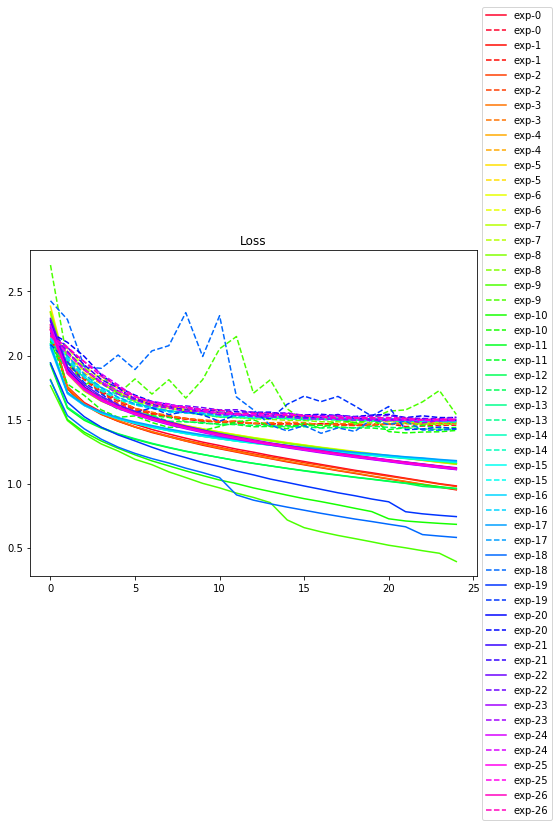

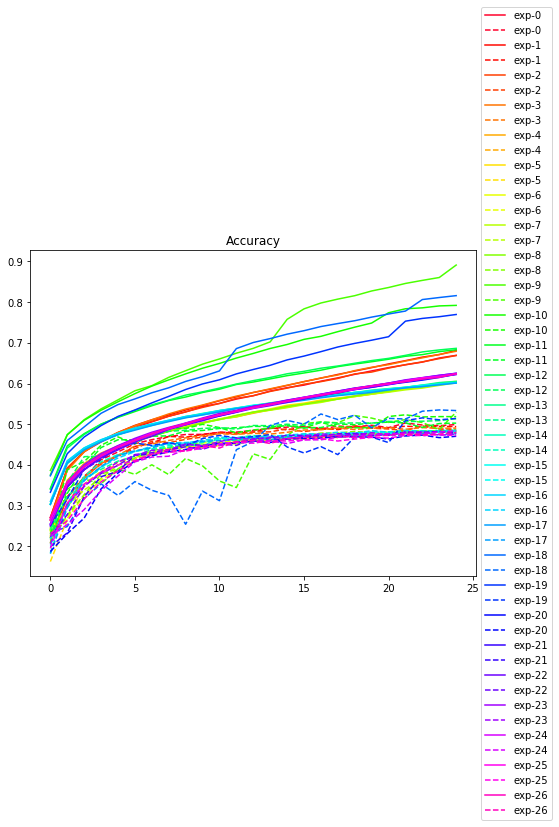

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()